In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import tensorboard
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers

In [2]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

2022-10-03 12:42:44.578332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1D generation

## Experiment 1
We generate from a multiplicative Y = AX.  
A is a gamma distribution with alpha = 3, beta = 0.5  
X is a inverse gamma distribution with alpha = 2.5, beta = 0.6  
The prior is InvGamma with alpha=3, beta=1   
The posterior is InvGamma with alpha = 3, beta learnable function of samples y  
The likelihood is a gamma distribution with alpha = 3 , beta learnable function of samples y  

In [4]:
tfd = tfp.distributions
encoded_size = 1
input_shape =(1,)
nbparamsl = 2
nbparamsobs = 2


In [5]:
A = tfd.Gamma(concentration = 3.0, rate=0.5).sample(1000)
X = tfd.InverseGamma(concentration =2.5, scale = 0.6 ).sample(1000)

Y=A*X
train_dataset = Y[:750]
train_dataset = tf.reshape(train_dataset,[750,1])
eval_dataset = Y[750:]
eval_dataset=tf.reshape(eval_dataset,[250,1])
print(eval_dataset)

2022-10-03 12:43:08.774788: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


tf.Tensor(
[[ 1.6723001 ]
 [ 0.30975646]
 [ 0.75991964]
 [ 1.7407728 ]
 [ 3.2403271 ]
 [ 1.4881463 ]
 [ 0.4217397 ]
 [ 0.302513  ]
 [ 3.146786  ]
 [ 3.0723789 ]
 [ 0.33614045]
 [ 2.5956914 ]
 [ 0.7009811 ]
 [ 2.1156113 ]
 [ 0.22034013]
 [ 1.6904477 ]
 [ 5.46438   ]
 [ 1.3919952 ]
 [ 0.5263376 ]
 [ 3.5323048 ]
 [ 2.1864624 ]
 [ 1.6459337 ]
 [ 0.46054426]
 [ 0.26688042]
 [ 9.481236  ]
 [ 7.642795  ]
 [ 0.16355075]
 [ 2.273376  ]
 [ 0.3064295 ]
 [ 4.5831513 ]
 [15.505759  ]
 [ 0.48646447]
 [ 0.54466045]
 [ 2.583576  ]
 [ 2.2547414 ]
 [ 2.7617986 ]
 [ 1.3531766 ]
 [ 3.8692677 ]
 [ 0.42213932]
 [ 0.7950214 ]
 [ 1.3098423 ]
 [ 1.9842157 ]
 [ 6.3772173 ]
 [ 0.68313587]
 [ 1.2525085 ]
 [ 2.5960195 ]
 [ 0.9025676 ]
 [ 2.519099  ]
 [ 1.4924542 ]
 [ 0.8870901 ]
 [ 1.6473445 ]
 [ 1.6923214 ]
 [ 1.1583532 ]
 [ 0.7909823 ]
 [ 0.92879695]
 [ 6.1981497 ]
 [ 1.5618217 ]
 [ 2.1263409 ]
 [ 2.3679414 ]
 [ 1.5631142 ]
 [ 1.7689413 ]
 [ 0.82435423]
 [10.503824  ]
 [ 2.485923  ]
 [ 0.48734164]
 [ 0.637299  ]

/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


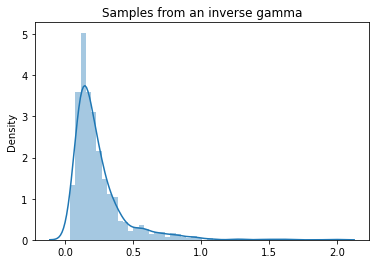

In [6]:
import inspect
#inspect.getargspec(tfd.InverseGamma)
invG = tfd.InverseGamma(concentration = 3, scale =0.5)
samples = invG.sample(1000)

sns.distplot(samples)
plt.title("Samples from an inverse gamma")
plt.show()


In [8]:
prior =tfd.InverseGamma(concentration =2.5, scale = 1 )

In [118]:
tfpl = tfp.layers
encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[1]),
    tfkl.Dense(1,
               activation=None),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
    tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.InverseGamma(
        concentration=3, scale=t),
    activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

In [119]:
c=tf.constant([[1.0],[2.0]])
print(encoder(c))
[print(np.squeeze(w.numpy())) for w in encoder.weights]

tfp.distributions._TensorCoercible("sequential_8_distribution_lambda_9_tensor_coercible", batch_shape=[2, 1], event_shape=[], dtype=float32)
1.272061
0.0


[None, None]

In [133]:
decoder = tfk.Sequential([
    tfkl.Dense(5, use_bias=True, activation='relu'),
    tfkl.Dense(5, use_bias=True, activation='relu'),
    tfkl.Dense(1, use_bias=True),
    tfkl.Lambda(lambda x: tf.abs(x)+0.001),
    tfpl.DistributionLambda(
    make_distribution_fn=lambda v: tfd.Gamma(
        concentration=3, rate=v)),
 #   convert_to_tensor_fn=lambda s: s.sample),
])

In [134]:
c=tf.constant([[1.0],[2.4]])
print(decoder(c))
[print(np.squeeze(w.numpy())) for w in decoder.weights]

tfp.distributions._TensorCoercible("sequential_10_distribution_lambda_11_tensor_coercible", batch_shape=[2, 1], event_shape=[], dtype=float32)
[ 0.20731306  0.6692159   0.9966419  -0.6877501   0.5273528 ]
[0. 0. 0. 0. 0.]
[[ 0.7150396  -0.7224742  -0.48862743  0.05529433 -0.09209478]
 [ 0.30872715  0.60687745 -0.6542005   0.04341304 -0.4448439 ]
 [-0.47304058  0.37507927 -0.18101865 -0.7659674  -0.04890776]
 [ 0.7609724   0.23689449 -0.08099395 -0.28638867  0.24504328]
 [-0.09517008 -0.15877694 -0.0993861   0.04263318 -0.6710544 ]]
[0. 0. 0. 0. 0.]
[ 0.28419447 -0.4424882  -0.6236043  -0.34777927 -0.8560598 ]
0.0


[None, None, None, None, None, None]

In [135]:
vae = tfk.Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs))
print(vae.output_shape)

(None, 1)


In [195]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
            loss=negative_log_likelihood)

In [196]:
vae.fit(train_dataset,train_dataset,batch_size=32,epochs=100)


Epoch 1/100
24/24 [==============================] - 1s 5ms/step - loss: 2.0717
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0623
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0630
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0606
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0752
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0691
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0733
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0810
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 2.0722
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 2.0797
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - loss: 2.0696
Epoch 12/100
24/24 [==============================] - 0s 5ms/step - loss: 2.0695
Epoch 13/100
24/24 [=================

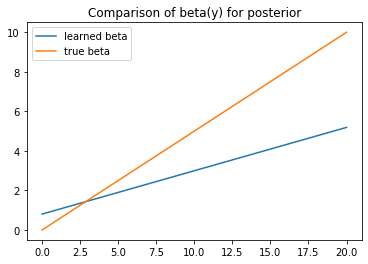

In [189]:
x =tf.linspace(
    0.001, 20, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)

beta_y = encoder(x).scale
plt.figure()
plt.title("Comparison of beta(y) for posterior")
plt.plot(x,beta_y,label='learned beta')
plt.plot(x,0.5*x, label = 'true beta')
plt.legend(['learned beta','true beta'])


<Figure size 432x288 with 0 Axes>

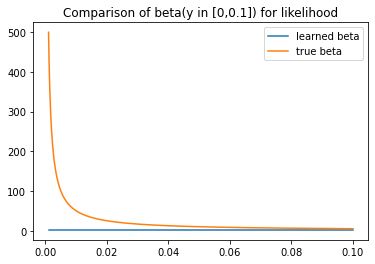

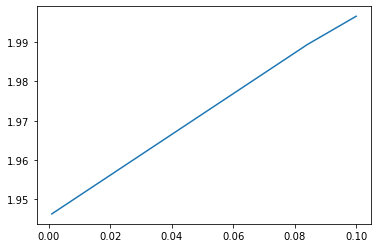

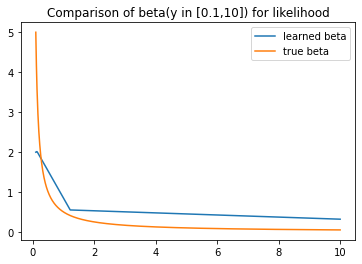

<Figure size 432x288 with 0 Axes>

In [190]:
x =tf.linspace(
    0.001, 0.1, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)
beta_x = decoder(x).rate
plt.figure()
plt.title("Comparison of beta(y in [0,0.1]) for likelihood")
plt.plot(x,beta_x,label='learned beta')
plt.plot(x,0.5/x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()
plt.plot(x,beta_x,label='learned beta')
x =tf.linspace(
    0.1, 10, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)
beta_x = decoder(x).rate
plt.figure()
plt.title("Comparison of beta(y in [0.1,10]) for likelihood")
plt.plot(x,beta_x,label='learned beta')
plt.plot(x,0.5/x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()


(1000,)
(1000,)


/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == '__main__':


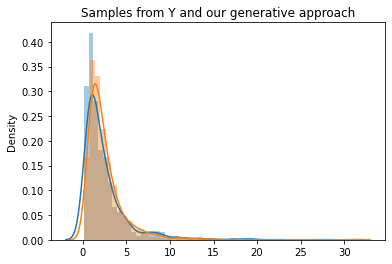

In [197]:
#Comparaison entre la densité de Y et de notre modèle génératif

samples_y = Y
print(samples_y.shape)
X_gen = prior.sample((1000,1))
samples_y_gen = tf.reshape(decoder(X_gen),(1000,))
print(samples_y_gen.shape)
sns.distplot(samples_y)
sns.distplot(samples_y_gen)
plt.title("Samples from Y and our generative approach")
plt.show()



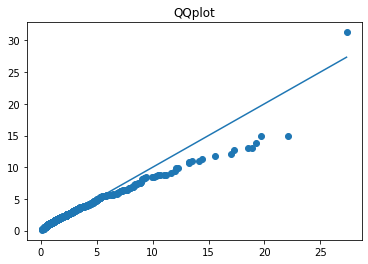

In [198]:

plt.figure()
plt.title('QQplot')
plt.scatter(tf.sort(samples_y),tf.sort(samples_y_gen))
plt.plot(tf.sort(samples_y),tf.sort(samples_y))

## Experiment 2
We generate from a multiplicative Y = AX.  
A is a gamma distribution with alpha = 3, beta = 0.5  
X is a inverse gamma distribution with alpha = 2.5, beta = 0.6  
The prior is InvGamma with alpha=2.5, beta=1   
The posterior is InvGamma with alpha constant learnable , beta learnable function of samples y  
The likelihood is a gamma distribution with alpha constant, beta learnable function of samples y  

In [57]:
zeros_traindataset=tf.zeros(train_dataset.shape)
print(zeros_traindataset.shape)

(750, 1)


In [109]:
Y_input = tfk.Input(
    shape=[1], name="Y_train"
)  
zeros_input = tfk.Input([1], name="Zeros_train")
beta_layer = tfkl.Dense(1,activation=None)(Y_input)
alpha_layer = tfkl.Dense(1,use_bias=True,activation=None, bias_initializer=tfk.initializers.Ones()
)(zeros_input)
alpha_layer = tfkl.Lambda(lambda x: tf.abs(x)+0.001)(alpha_layer)
beta_layer = tfkl.Lambda(lambda x: tf.abs(x)+0.001,name = 'inv_gamma_beta_posterior')(beta_layer)
alpha_beta = tfkl.Concatenate()([alpha_layer,beta_layer])
posterior = tfpl.DistributionLambda(
    make_distribution_fn=lambda t: tfd.InverseGamma(
        concentration=t[... , 0], scale=t[...,1]),
    activity_regularizer=tfpl.KLDivergenceRegularizer(prior),
)(alpha_beta)
posterior = tfkl.Reshape(target_shape=[1])(posterior) 
print(posterior.shape)
encoder2 = tfk.Model(
    inputs=[Y_input,zeros_input],
    outputs=[posterior, alpha_layer],
)


(None, 1)


In [61]:
encoder2.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Zeros_train (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 Y_train (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_35 (Dense)               (None, 1)            2           ['Zeros_train[0][0]']            
                                                                                                  
 dense_34 (Dense)               (None, 1)            2           ['Y_train[0][0]']                
                                                                                           

In [62]:
post_input = tfk.Input(
    shape=[1], name="post_input"
)  
alpha_input = tfk.Input([1], name="alpha_input")

beta_deco = tfkl.Dense(5, use_bias=True, activation='relu')(post_input)
beta_deco = tfkl.Dense(5, use_bias=True, activation='relu')(beta_deco)
beta_deco = tfkl.Dense(1, use_bias=True)(beta_deco)
beta_deco = tfkl.Lambda(lambda x: tf.abs(x)+0.001)(beta_deco)
alpha_beta = tfkl.Concatenate()([alpha_input,beta_deco])
out = tfpl.DistributionLambda(
make_distribution_fn=lambda v: tfd.Gamma(
        concentration=v[...,0], rate=v[...,1]),       
)(alpha_beta)
decoder2 = tfk.Model(
    inputs=[post_input,alpha_input],
    outputs=out
)
 #   convert_to_tensor_fn=lambda s: s.sample),


In [63]:
decoder2.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 post_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 dense_36 (Dense)               (None, 5)            10          ['post_input[0][0]']             
                                                                                                  
 dense_37 (Dense)               (None, 5)            30          ['dense_36[0][0]']               
                                                                                                  
 dense_38 (Dense)               (None, 1)            6           ['dense_37[0][0]']               
                                                                                           

In [174]:
vae2 = tfk.Model(inputs=encoder2.inputs,
                outputs=decoder2(encoder2.outputs))
print(vae2.output_shape)

(None,)


In [149]:
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

vae2.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3),
            loss=negative_log_likelihood)

In [150]:
c=tf.constant([[1.0],[2.0]])
z = tf.constant([[0.0],[0.0]])
print(encoder2([c,z]))
[print(np.squeeze(w.numpy())) for w in encoder2.weights]

[<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.17473216],
       [0.8775243 ]], dtype=float32)>, <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.535697],
       [1.535697]], dtype=float32)>]
1.7007588
1.5346969
-0.8867608
0.051259764


[None, None, None, None]

In [171]:
vae2.fit(
    {"Y_train" : train_dataset, "Zeros_train" : zeros_traindataset},
    train_dataset,
    validation_data = ((eval_dataset,tf.zeros(eval_dataset.shape)),eval_dataset),
         batch_size=16,epochs=100)


Epoch 1/100
47/47 [==============================] - 1s 20ms/step - loss: 1.9165 - val_loss: 2.0151
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: 1.8997 - val_loss: 1.9910
Epoch 3/100
47/47 [==============================] - 0s 7ms/step - loss: 1.9077 - val_loss: 2.0147
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 1.9120 - val_loss: 1.9997
Epoch 5/100
47/47 [==============================] - 0s 8ms/step - loss: 1.9152 - val_loss: 1.9767
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: 1.9304 - val_loss: 2.0108
Epoch 7/100
47/47 [==============================] - 0s 8ms/step - loss: 1.8965 - val_loss: 2.0347
Epoch 8/100
47/47 [==============================] - 0s 8ms/step - loss: 1.9216 - val_loss: 2.0045
Epoch 9/100
47/47 [==============================] - 0s 7ms/step - loss: 1.9055 - val_loss: 2.0312
Epoch 10/100
47/47 [==============================] - 0s 8ms/step - loss: 1.8895 - val_loss: 2.0053
Epoch 11

In [172]:
layer_name = 'inv_gamma_beta_posterior'
intermediate_layer_model = tfk.Model(inputs=encoder2.input,
                                       outputs=encoder2.get_layer(layer_name).output)

tf.Tensor([1.9359263], shape=(1,), dtype=float32)


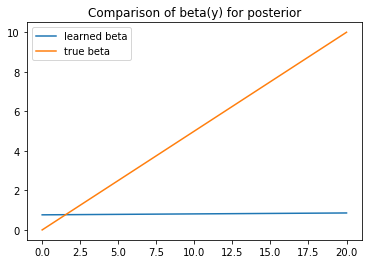

In [173]:
x =tf.linspace(
    0.001, 20, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)

x_tot = [x,tf.zeros(x.shape)]
beta_y = intermediate_layer_model(x_tot)

print(encoder2(x_tot)[1][0])

plt.figure()
plt.title("Comparison of beta(y) for posterior")
plt.plot(x,beta_y,label='learned beta')
plt.plot(x,0.5*x, label = 'true beta')
plt.legend(['learned beta','true beta'])


<Figure size 432x288 with 0 Axes>

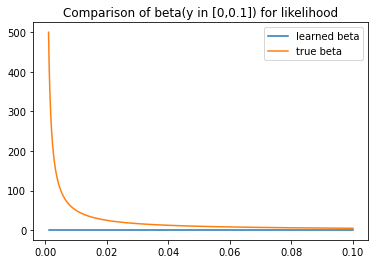

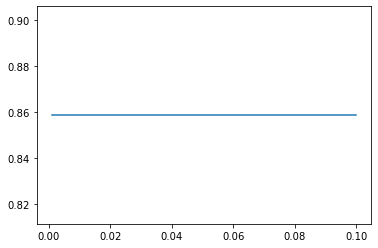

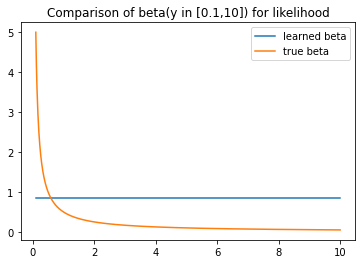

<Figure size 432x288 with 0 Axes>

In [163]:
x =tf.linspace(
    0.001, 0.1, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)
alpha_y = encoder2(x_tot)[1]
beta_x = decoder2([x,alpha_y]).rate
plt.figure()
plt.title("Comparison of beta(y in [0,0.1]) for likelihood")
plt.plot(x,beta_x,label='learned beta')
plt.plot(x,0.5/x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()
plt.plot(x,beta_x,label='learned beta')
x =tf.linspace(
    0.1, 10, 1000, name=None, axis=0
)
x = tf.expand_dims(x,-1)
beta_x = decoder2([x,alpha_y]).rate
plt.figure()
plt.title("Comparison of beta(y in [0.1,10]) for likelihood")
plt.plot(x,beta_x,label='learned beta')
plt.plot(x,0.5/x, label = 'true beta')
plt.legend(['learned beta','true beta'])
plt.figure()

(1000,)
(1000,)


/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  
/home/nlafon/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == '__main__':


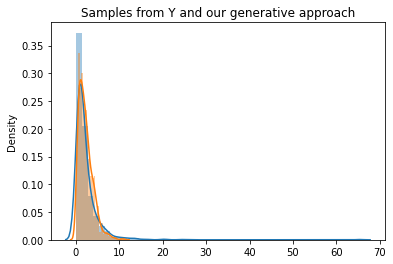

In [168]:
#Comparaison entre la densité de Y et de notre modèle génératif

samples_y = Y
print(samples_y.shape)
X_gen = prior.sample((1000,1))
samples_y_gen = tf.reshape(decoder2([X_gen,alpha_y]),(1000,))
print(samples_y_gen.shape)
sns.distplot(samples_y)
sns.distplot(samples_y_gen)
plt.title("Samples from Y and our generative approach")
plt.show()



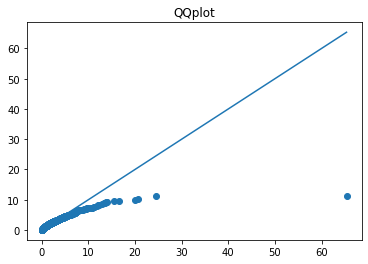

In [166]:

plt.figure()
plt.title('QQplot')
plt.scatter(tf.sort(samples_y),tf.sort(samples_y_gen))
plt.plot(tf.sort(samples_y),tf.sort(samples_y))